In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from collections import Counter

np.random.seed(42)

In [3]:
# Load the dataset from Hugging Face
dataset = load_dataset("imdb")

# Check dataset structure
print(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [4]:
# Get training data
df_train = pd.DataFrame(dataset["train"])
df_test = pd.DataFrame(dataset["test"])

# Print an example
df_train.loc[0, "text"]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

* label=1 → Positive review
* label=0 → Negative review

## Data processing

In [5]:
# Preprocessing function
def clean_text(text):
    text = re.sub(r"<br\s*/?>", " ", text)  # Remove <br> HTML tags

    # Remove punctuation and numbers
    text = re.sub(r"[^a-zA-Z]", " ", text)

    # Single character removal
    text = re.sub(r"\s+[a-zA-Z]\s+", " ", text)

    # Remove multiple spaces
    text = re.sub(r"\s+", " ", text)

    return text

def remove_html_tags(text):
    text = re.sub(r"<br\s*/?>", " ", text)
    return text

In [6]:
# Apply preprocessing
df_train["clean_text"] = df_train["text"].apply(clean_text)
df_test["clean_text"] = df_test["text"].apply(clean_text)
df_train["text"] = df_train["text"].apply(remove_html_tags)
df_test["text"] = df_test["text"].apply(remove_html_tags)

# Display cleaned dataset
df_train.head()

,text,label,clean_text
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,I rented AM CURIOUS YELLOW from my video store...
1,"""I Am Curious: Yellow"" is a risible and preten...",0,Am Curious Yellow is risible and pretentious ...
2,If only to avoid making this type of film in t...,0,If only to avoid making this type of film in t...
3,This film was probably inspired by Godard's Ma...,0,This film was probably inspired by Godard Masc...
4,"Oh, brother...after hearing about this ridicul...",0,Oh brother after hearing about this ridiculous...


In [7]:
df_train.describe()

,label
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        25000 non-null  object
 1   label       25000 non-null  int64 
 2   clean_text  25000 non-null  object
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


In [9]:
print(df_train.isna().sum())
print(df_test.isna().sum())

text          0
label         0
clean_text    0
dtype: int64
text          0
label         0
clean_text    0
dtype: int64


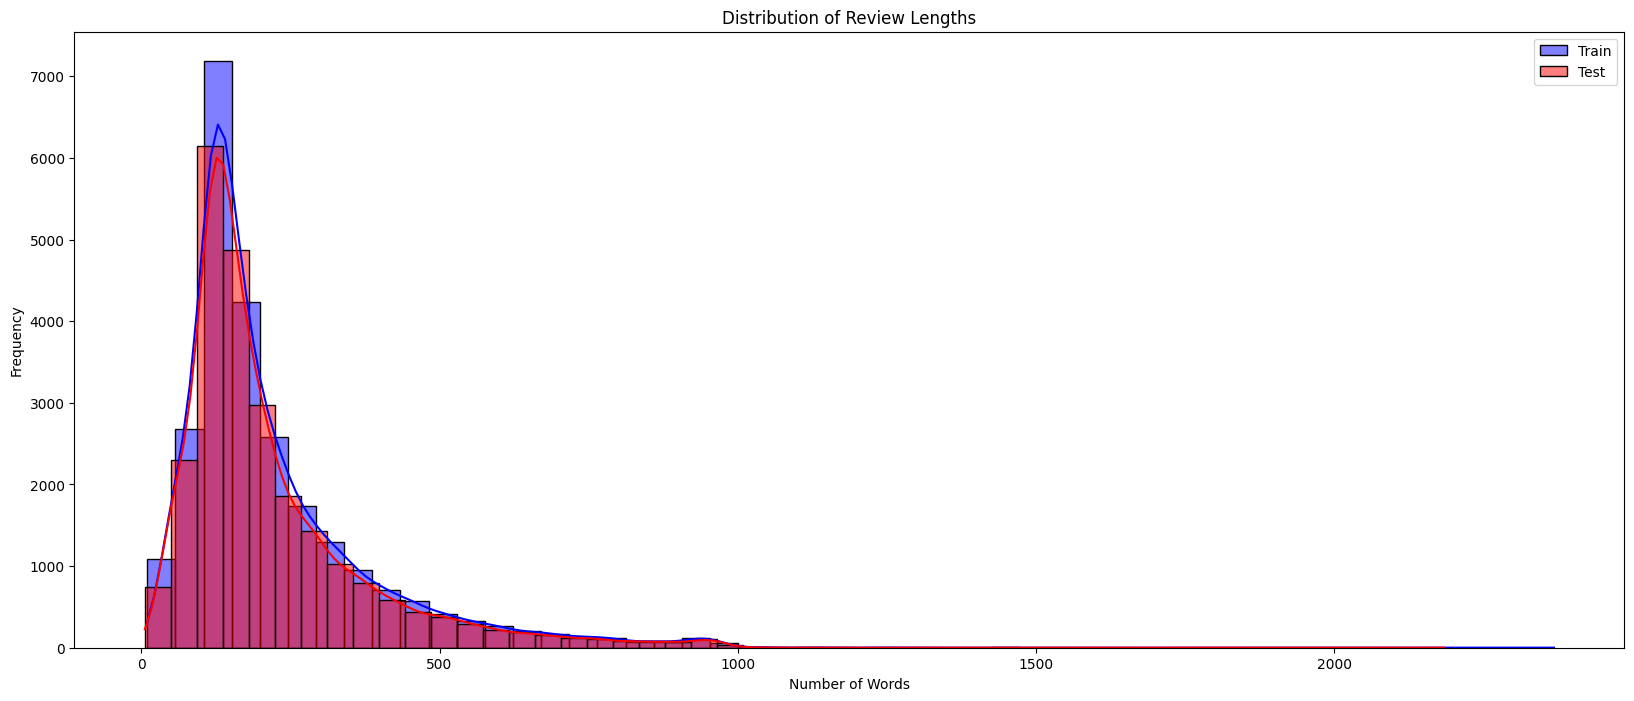

In [10]:
# Calculate review lengths
df_train["review_length"] = df_train["clean_text"].apply(lambda x: len(x.split()))
df_test["review_length"] = df_test["clean_text"].apply(lambda x: len(x.split()))

# Plot histogram
plt.figure(figsize=(20, 8))
sns.histplot(df_train["review_length"], bins=50, kde=True, color="blue", label="Train")
sns.histplot(df_test["review_length"], bins=50, kde=True, color="red", label="Test")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.title("Distribution of Review Lengths")
plt.legend()
plt.show()

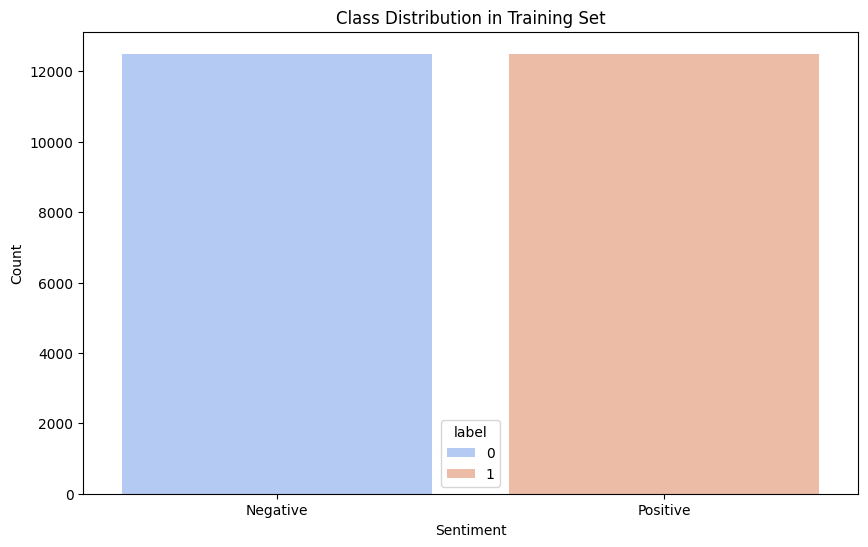

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df_train["label"], hue=df_train["label"], palette="coolwarm")
plt.xticks([0, 1], ["Negative", "Positive"])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Class Distribution in Training Set")
plt.show()

## Model training

In [12]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, classification_report
from sklearn.model_selection import learning_curve, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

from sklearn.preprocessing import LabelEncoder
import pickle

tf.random.set_seed(42)

In [13]:
def plot_learning_curve(model, X_train, y_train, title):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=StratifiedKFold(n_splits=5),  # Ensuring balanced splits
        scoring="accuracy", train_sizes=np.linspace(0.6, 1.0, 10)
    )

    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, label="Training Accuracy", marker='o')
    plt.plot(train_sizes, test_mean, label="Validation Accuracy", marker='s')
    plt.xlabel("Training Size")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.show()

In [14]:
X_train = df_train["clean_text"]
y_train = df_train["label"]
X_test = df_test["clean_text"]
y_test = df_test["label"]

In [15]:
# Vectorization (TF-IDF)
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [16]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(25000, 73246) (25000,) (25000, 73246) (25000,)


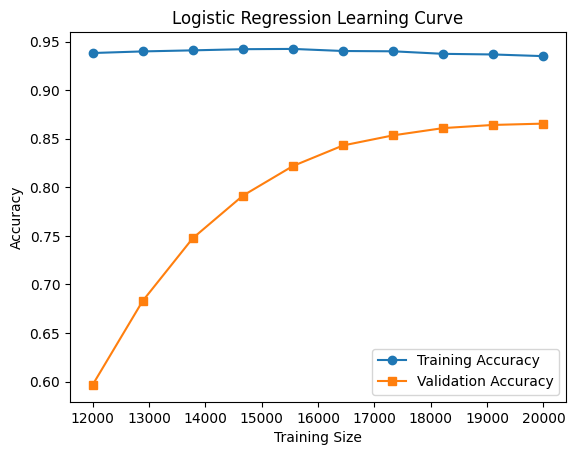

In [17]:
# Logistic Regression
log_reg = LogisticRegression(random_state=42)
plot_learning_curve(log_reg, X_train, y_train, "Logistic Regression Learning Curve")

In [18]:
# Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Accuracy:", accuracy)
print(classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.88256
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



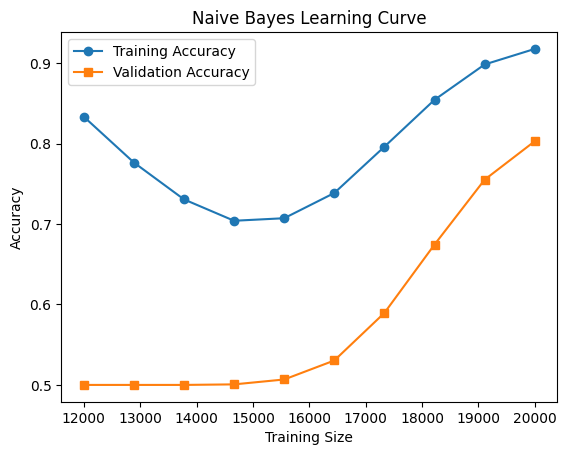

In [19]:
# Naive Bayes
nb = MultinomialNB()
plot_learning_curve(nb, X_train, y_train, "Naive Bayes Learning Curve")

In [20]:
# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Accuracy:", accuracy)
print(classification_report(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.83104
              precision    recall  f1-score   support

           0       0.80      0.89      0.84     12500
           1       0.87      0.77      0.82     12500

    accuracy                           0.83     25000
   macro avg       0.84      0.83      0.83     25000
weighted avg       0.84      0.83      0.83     25000



In [21]:
max_review_length = max(df_train["review_length"].max(), df_test["review_length"].max())
print("Maximum review length:", max_review_length)

average_review_length = (df_train["review_length"].mean() + df_test["review_length"].mean()) / 2
print("Average review length:", average_review_length)

review_lengths = df_train[df_train["review_length"] <= 512]
percent_below_512 = len(review_lengths) / len(df_train) * 100
print(f"Percentage of reviews ≤512 tokens: {percent_below_512:.2f}%")

Maximum review length: 2368
Average review length: 220.35237999999998
Percentage of reviews ≤512 tokens: 93.21%


In [22]:
all_words = [word for text in df_train["text"] for word in text.split()]
vocab_size = len(Counter(all_words))
print("Total unique words:", vocab_size)


Total unique words: 264870


In [23]:
max_length = int(df_train["review_length"].quantile(0.95))  # 95th percentile
print("Max Length:", max_length)

Max Length: 573


In [24]:
# CNN

# Tokenization & Padding
max_vocab_size = 100000  # Limit vocabulary size
max_length = 512  # Fixed length for padding

tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train["text"])

X_train_seq = tokenizer.texts_to_sequences(df_train["clean_text"])
X_test_seq = tokenizer.texts_to_sequences(df_test["clean_text"])

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

# Convert labels to numpy array
y_train = np.array(y_train)
y_test = np.array(y_test)

In [25]:
# Hyperparameters
embedding_dim = 128
num_filters = 64  # Number of filters (kernels)
kernel_size = 5  # Size of each filter
dropout_rate = 0.7

# Model architecture
cnn_model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=embedding_dim),
    Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    GlobalMaxPooling1D(),  # Reduces dimensionality
    Dropout(dropout_rate),
    Dense(64, activation='relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')  # Binary classification (positive/negative sentiment)
])

# Compile model
cnn_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [39]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 512, 128)            │      12,800,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 508, 64)             │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,535,749 (147.00 MB)

 Trainable params: 12,845,249 (49.00 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,690,500 (98.00 MB)

In [26]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_accuracy',  # Monitor validation accuracy
                               patience=3,             # Number of epochs to wait for improvement
                               restore_best_weights=True,  # Restore the best model weights
                               verbose=1)

# Define model checkpoint to save the best model based on validation accuracy
checkpoint = ModelCheckpoint('best_model.h5',         # File name to save the best model
                             monitor='val_accuracy',   # Monitor validation accuracy
                             save_best_only=True,       # Save only the best model
                             verbose=1)

# Train the model with early stopping and model checkpoint
history = cnn_model.fit(X_train_pad, y_train,
                         validation_data=(X_test_pad, y_test),
                         epochs=10,
                         batch_size=64,
                         callbacks=[early_stopping, checkpoint])  # Add both callbacks

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.5268 - loss: 0.8959
Epoch 1: val_accuracy improved from -inf to 0.74828, saving model to best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 230s 580ms/step - accuracy: 0.5269 - loss: 0.8955 - val_accuracy: 0.7483 - val_loss: 0.5521
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.7421 - loss: 0.5695
Epoch 2: val_accuracy improved from 0.74828 to 0.83728, saving model to best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 199s 510ms/step - accuracy: 0.7422 - loss: 0.5695 - val_accuracy: 0.8373 - val_loss: 0.4333
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.8321 - loss: 0.4578
Epoch 3: val_accuracy improved from 0.83728 to 0.84824, saving model to best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 182s 458ms/step - accuracy: 0.8321 - loss: 0.4577 - val_accuracy: 0.8482 - val_loss: 0.4141
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.8744 - loss: 0.3800
Epoch 4: val_accuracy improved from 0.84824 to 0.84940, saving model to best_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 194s 496ms/step - accuracy: 0.8744 - loss: 0.3799 - val_accuracy: 0.8494 - val_loss: 0.4119
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9017 - loss: 0.3210
Epoch 5: val_accuracy did not improve from 0.84940
391/391 ━━━━━━━━━━━━━━━━━━━━ 208s 511ms/step - accuracy: 0.9017 - loss: 0.3210 - val_accuracy: 0.8453 - val_loss: 0.4270
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.9231 - loss: 0.2739
Epoch 6: val_accuracy did not improve from 0.84940
391/391 ━━━━━━━━━━━━━━━━━━━━ 203s 513ms/step - accuracy: 0.9232 - loss: 0.2739 - val_accuracy: 0.8326 - val_loss: 0.4643
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9304 - loss: 0.2540
Epoch 7: val_accuracy did not improve from 0.84940
391/391 ━━━━━━━━━━━━━━━━━━━━ 212s 538ms/step - accuracy: 0.9304 - loss: 0.2540 - val_accuracy: 0.8319 - val_loss: 0.4869
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.


In [27]:
# Save history
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [28]:
# Load the saved history
with open('training_history.pkl', 'rb') as f:
    history = pickle.load(f)

In [29]:
# Load the best model
best_model = load_model('best_model.h5')

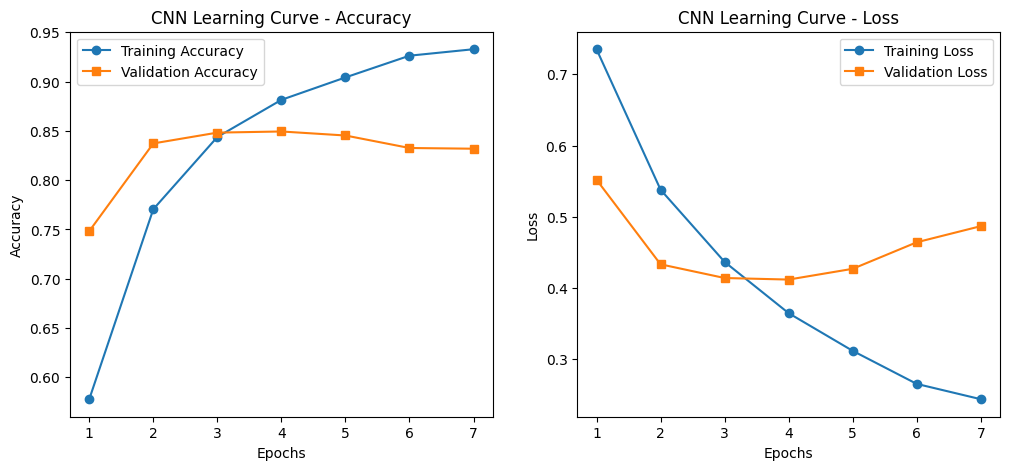

In [30]:
epochs = range(1, len(history['accuracy']) + 1)

plt.figure(figsize=(12, 5))

# Accuracy Learning Curve
plt.subplot(1, 2, 1)
plt.plot(epochs, history['accuracy'], label="Training Accuracy", marker='o')
plt.plot(epochs, history['val_accuracy'], label="Validation Accuracy", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("CNN Learning Curve - Accuracy")
plt.legend()

# Loss Learning Curve
plt.subplot(1, 2, 2)
plt.plot(epochs, history['loss'], label="Training Loss", marker='o')
plt.plot(epochs, history['val_loss'], label="Validation Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("CNN Learning Curve - Loss")
plt.legend()

plt.show()

## Visualization

In [31]:
def plot_confusion_matrix(y_true, y_pred, model_name):
  cm = confusion_matrix(y_true, y_pred)

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
              xticklabels=["Negative", "Positive"],
              yticklabels=["Negative", "Positive"])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title(f"Confusion Matrix for {model_name}")
  plt.show()

def plot_roc_curve(model, X_test, y_test, model_name):
  if model_name == "CNN":
    y_probs = model.predict(X_test).flatten()
  else:
    y_probs = model.predict_proba(X_test)[:, 1]  # Get probability of class 1

  fpr, tpr, _ = roc_curve(y_test, y_probs)
  roc_auc = auc(fpr, tpr)

  plt.figure(figsize=(6, 6))
  plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
  plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random chance
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title(f"ROC Curve - {model_name}")
  plt.legend(loc="lower right")
  plt.show()

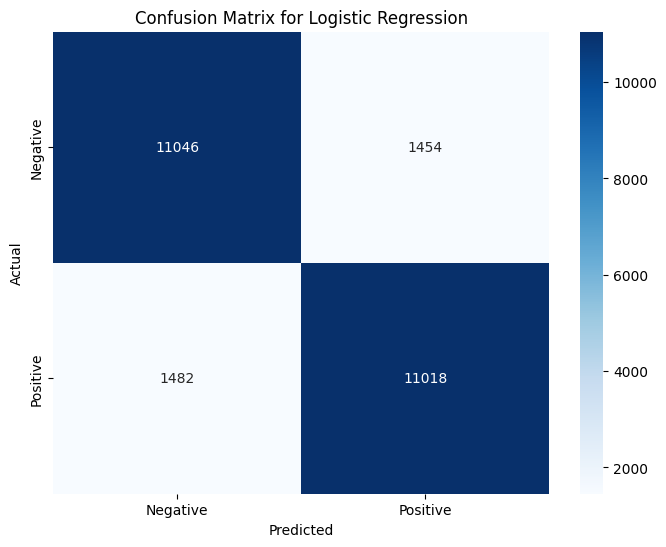

In [32]:
plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression")

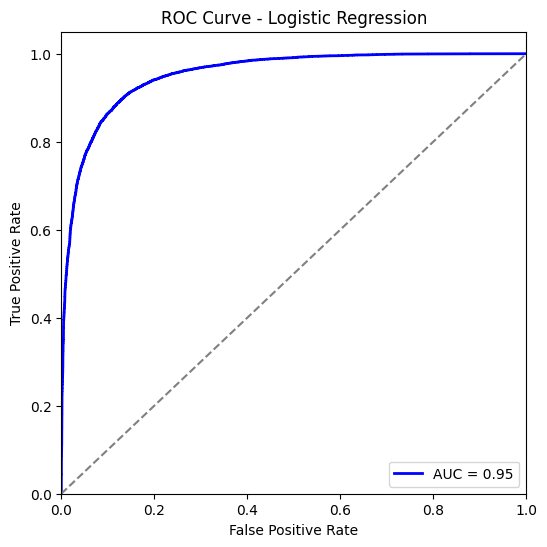

In [33]:
plot_roc_curve(log_reg, X_test, y_test, "Logistic Regression")

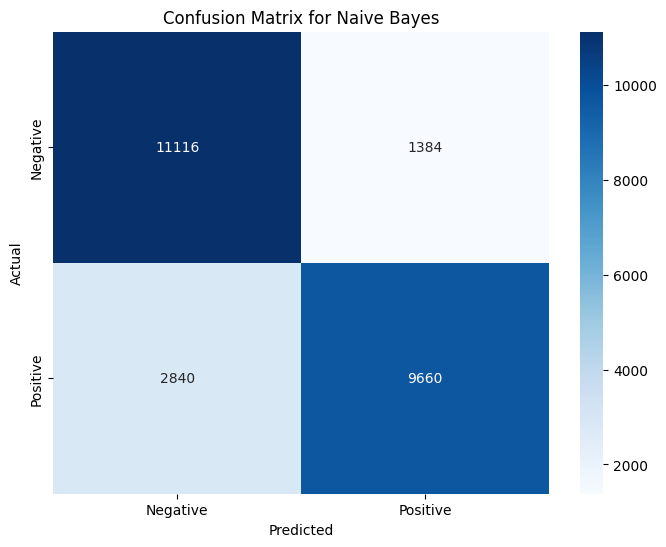

In [34]:
plot_confusion_matrix(y_test, y_pred_nb, "Naive Bayes")

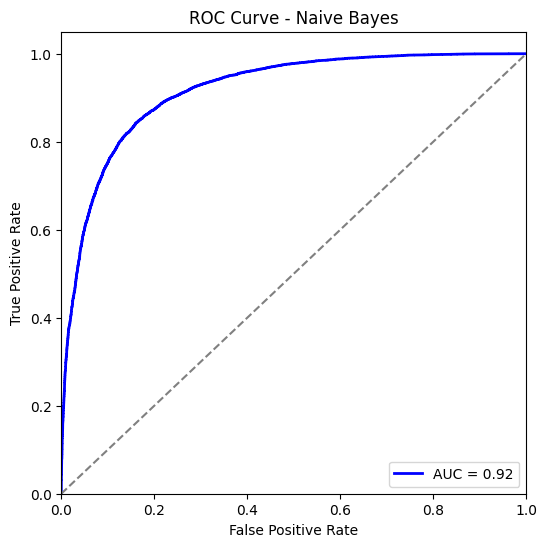

In [35]:
plot_roc_curve(nb, X_test, y_test, "Naive Bayes")

782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step


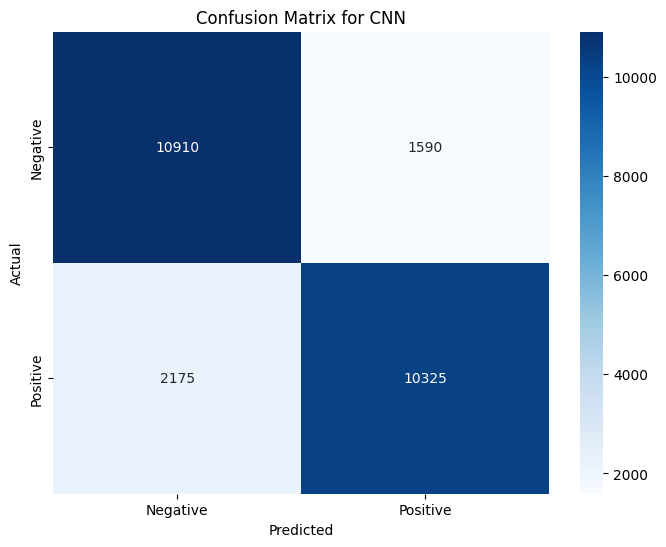

In [36]:
y_pred_cnn = (cnn_model.predict(X_test_pad) > 0.5).astype("int32")
plot_confusion_matrix(y_test, y_pred_cnn, "CNN")

782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step


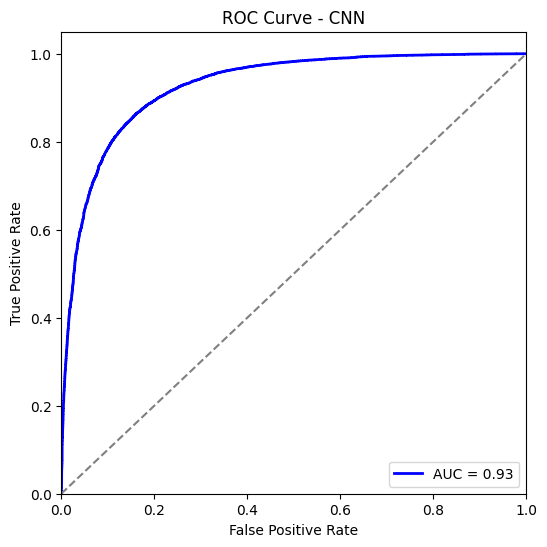

In [37]:
plot_roc_curve(cnn_model, X_test_pad, y_test, "CNN")